In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,9796,CA-2017-125920,21/05/2017,28/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.7980
9796,9797,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.3680
9797,9798,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.1880
9798,9799,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.3760


In [4]:
data = data.drop(['Row ID'], axis=1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9800 non-null   object 
 1   Order Date     9800 non-null   object 
 2   Ship Date      9800 non-null   object 
 3   Ship Mode      9800 non-null   object 
 4   Customer ID    9800 non-null   object 
 5   Customer Name  9800 non-null   object 
 6   Segment        9800 non-null   object 
 7   Country        9800 non-null   object 
 8   City           9800 non-null   object 
 9   State          9800 non-null   object 
 10  Postal Code    9789 non-null   float64
 11  Region         9800 non-null   object 
 12  Product ID     9800 non-null   object 
 13  Category       9800 non-null   object 
 14  Sub-Category   9800 non-null   object 
 15  Product Name   9800 non-null   object 
 16  Sales          9800 non-null   float64
dtypes: float64(2), object(15)
memory usage: 1.3+ MB


Это данные о заказах в магазине, взято с [Kaggle](https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting).

Order ID - ID заказа \
Order Date - дата заказа \
Ship Date - дата отправки заказа \
Ship Mode - класс доставки \
Customer ID - ID покупателя \
Customer Name - имя покупателя \
Segment - сегмент рынка (Cunsomer, Corporate, Home Office) \
Country - страна \
City - город \
State - штат \
Postal Code - почтовый индекс \
Region - регион (центральный, восточный, южный, западный) \
Product ID - ID товара \
Category - категория товара \
Sub-Category - подкатегория товара \
Product Name - название товара \
Sales - сумма продаж (может быть цена товара, не уверен)

Цель проекта: узнать как соотносятся продажи в декабре и январе, построить предсказание продаж на год вперед.

### **Предобработка данных**

In [6]:
data['Country'].unique()

array(['United States'], dtype=object)

Только одна страна - можно выбросить этот столбец.

In [7]:
data = data.drop(['Country'], axis=1)

Также уберем Customer ID, Customer Name, Product ID, Product Name, так как нам не нужна информация об отдельных клиентах и товарах. Также уберем City, State, Postal Code.

In [8]:
data = data.drop(['Customer ID'], axis=1)
data = data.drop(['Customer Name'], axis=1)
data = data.drop(['City'], axis=1)
data = data.drop(['State'], axis=1)
data = data.drop(['Postal Code'], axis=1)
data = data.drop(['Product ID'], axis=1)
data = data.drop(['Product Name'], axis=1)

Проверим отсутствие незаполненных полей.

In [9]:
data.isnull().sum()

Order ID        0
Order Date      0
Ship Date       0
Ship Mode       0
Segment         0
Region          0
Category        0
Sub-Category    0
Sales           0
dtype: int64

Переведем столбцы с датами в datetime.

In [10]:
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Ship Date'] = pd.to_datetime(data['Ship Date'])
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%Y-%m-%d')
data['Ship Date'] = pd.to_datetime(data['Ship Date'], format='%Y-%m-%d')

Отсортируем заказы по дате заказа.

In [11]:
data = data.sort_values('Order Date')

In [12]:
data['Order Date'].min()

Timestamp('2015-01-02 00:00:00')

In [13]:
data['Order Date'].max()

Timestamp('2018-12-30 00:00:00')

Данные охватывают промежуток времени с начала 2015 года до конца 2018 года.

Создадим столбцы Month - номер месяца в году, DoM (Day of Month) - номер дня в месяце, MfS (Month from Start) - номер месяца с начала рассматриваемого периода, WfS (Week from Start) - номер недели с начала рассматриваемого периода.

In [14]:
data['Month'] = data['Order Date'].dt.month
data['DoM'] = data['Order Date'].dt.day

In [15]:
data['MfS'] = data['Month'] + (data['Order Date'].dt.year - 2015) * 12  # 12 - число месяцев в году

In [16]:
data['WfS'] = data['Order Date'].dt.week + (data['Order Date'].dt.year - 2015) * 52  # в году обычно 52 недели

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 540 to 1297
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order ID      9800 non-null   object        
 1   Order Date    9800 non-null   datetime64[ns]
 2   Ship Date     9800 non-null   datetime64[ns]
 3   Ship Mode     9800 non-null   object        
 4   Segment       9800 non-null   object        
 5   Region        9800 non-null   object        
 6   Category      9800 non-null   object        
 7   Sub-Category  9800 non-null   object        
 8   Sales         9800 non-null   float64       
 9   Month         9800 non-null   int64         
 10  DoM           9800 non-null   int64         
 11  MfS           9800 non-null   int64         
 12  WfS           9800 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(6)
memory usage: 1.0+ MB


### **Визуальный анализ данных**

Посмотрим, какие есть различные категории.

In [18]:
data['Category'].unique()

array(['Technology', 'Furniture', 'Office Supplies'], dtype=object)

Посмотрим, какие есть подкатегории у каждой категории:

In [19]:
print(data[data['Category'] == 'Furniture']['Sub-Category'].unique())
print(data[data['Category'] == 'Technology']['Sub-Category'].unique())
print(data[data['Category'] == 'Office Supplies']['Sub-Category'].unique())

['Chairs' 'Furnishings' 'Tables' 'Bookcases']
['Accessories' 'Phones' 'Copiers' 'Machines']
['Paper' 'Storage' 'Fasteners' 'Binders' 'Labels' 'Appliances' 'Art'
 'Envelopes' 'Supplies']


Различные Ship Mode, Region и Segment:

In [20]:
data['Ship Mode'].unique()

array(['First Class', 'Standard Class', 'Second Class', 'Same Day'],
      dtype=object)

In [21]:
data['Region'].unique()

array(['Central', 'East', 'West', 'South'], dtype=object)

In [22]:
data['Segment'].unique()

array(['Consumer', 'Home Office', 'Corporate'], dtype=object)

Создадим датасет tmp, в котором закодируем признаки Segment, Ship Mode, Region, Category и Sub-Category, чтобы потом проверить, есть ли корреляция между признаками. 

In [23]:
tmp = data.copy()
tmp.loc[(tmp['Segment'] == 'Consumer'), 'Segment'] = 1
tmp.loc[(tmp['Segment'] == 'Corporate'), 'Segment'] = 2
tmp.loc[(tmp['Segment'] == 'Home Office'), 'Segment'] = 3
tmp['Segment'] = tmp['Segment'].astype(float)

tmp.loc[(tmp['Ship Mode'] == 'First Class'), 'Ship Mode'] = 1
tmp.loc[(tmp['Ship Mode'] == 'Standard Class'), 'Ship Mode'] = 2
tmp.loc[(tmp['Ship Mode'] == 'Second Class'), 'Ship Mode'] = 3
tmp.loc[(tmp['Ship Mode'] == 'Same Day'), 'Ship Mode'] = 4
tmp['Ship Mode'] = tmp['Ship Mode'].astype(float)

tmp.loc[(tmp['Region'] == 'Central'), 'Region'] = 1
tmp.loc[(tmp['Region'] == 'West'), 'Region'] = 2
tmp.loc[(tmp['Region'] == 'East'), 'Region'] = 3
tmp.loc[(tmp['Region'] == 'South'), 'Region'] = 4
tmp['Region'] = tmp['Region'].astype(float)

tmp.loc[(tmp['Category'] == 'Technology'), 'Category'] = 1
tmp.loc[(tmp['Category'] == 'Furniture'), 'Category'] = 2
tmp.loc[(tmp['Category'] == 'Office Supplies'), 'Category'] = 3
tmp['Category'] = tmp['Category'].astype(float)

tmp.loc[(tmp['Sub-Category'] == 'Chairs'), 'Sub-Category'] = 2.1
tmp.loc[(tmp['Sub-Category'] == 'Furnishings'), 'Sub-Category'] = 2.2
tmp.loc[(tmp['Sub-Category'] == 'Tables'), 'Sub-Category'] = 2.3
tmp.loc[(tmp['Sub-Category'] == 'Bookcases'), 'Sub-Category'] = 2.4
tmp.loc[(tmp['Sub-Category'] == 'Accessories'), 'Sub-Category'] = 1.1
tmp.loc[(tmp['Sub-Category'] == 'Phones'), 'Sub-Category'] = 1.2
tmp.loc[(tmp['Sub-Category'] == 'Copiers'), 'Sub-Category'] = 1.3
tmp.loc[(tmp['Sub-Category'] == 'Machines'), 'Sub-Category'] = 1.4
tmp.loc[(tmp['Sub-Category'] == 'Paper'), 'Sub-Category'] = 3.1
tmp.loc[(tmp['Sub-Category'] == 'Storage'), 'Sub-Category'] = 3.2
tmp.loc[(tmp['Sub-Category'] == 'Fasteners'), 'Sub-Category'] = 3.3
tmp.loc[(tmp['Sub-Category'] == 'Binders'), 'Sub-Category'] = 3.4
tmp.loc[(tmp['Sub-Category'] == 'Labels'), 'Sub-Category'] = 3.5
tmp.loc[(tmp['Sub-Category'] == 'Appliances'), 'Sub-Category'] = 3.6
tmp.loc[(tmp['Sub-Category'] == 'Art'), 'Sub-Category'] = 3.7
tmp.loc[(tmp['Sub-Category'] == 'Envelopes'), 'Sub-Category'] = 3.8
tmp.loc[(tmp['Sub-Category'] == 'Supplies'), 'Sub-Category'] = 3.9
tmp['Sub-Category'] = tmp['Sub-Category'].astype(float)

In [24]:
tmp.dtypes

Order ID                object
Order Date      datetime64[ns]
Ship Date       datetime64[ns]
Ship Mode              float64
Segment                float64
Region                 float64
Category               float64
Sub-Category           float64
Sales                  float64
Month                    int64
DoM                      int64
MfS                      int64
WfS                      int64
dtype: object

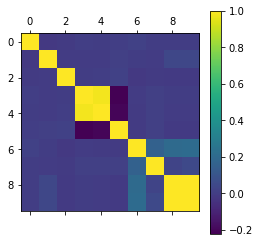

In [25]:
plt.matshow(tmp.corr())
cb = plt.colorbar()
plt.show()

Корреляция везде достаточно незначительная, кроме очевидно связанных между собой признаков (Category и Sub-Category; MfS и WfS).

Посмотрим на распределение сегментов рынка:

<AxesSubplot:xlabel='Segment', ylabel='Count'>

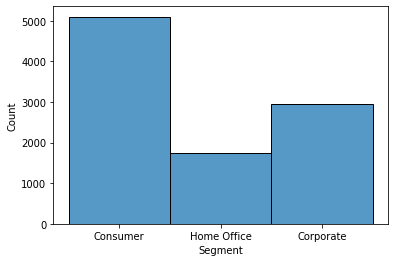

In [26]:
sns.histplot(data.Segment)

Примерно половина всех купленных товаров приходится на отдельных потребителей (Consumer).

Распределение по регионам:

<AxesSubplot:xlabel='Region', ylabel='Count'>

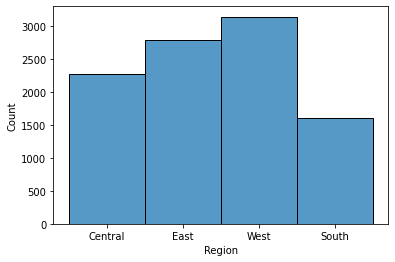

In [27]:
sns.histplot(data.Region)

Больше всего покупок приходится на западный регион.

Посмотрим на способы доставки:

<AxesSubplot:xlabel='Ship Mode', ylabel='Count'>

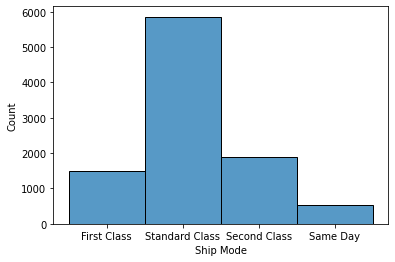

In [28]:
sns.histplot(data['Ship Mode'])

Большая часть товаров доставляется как Standard Class.

Теперь посмотрим на распределение покупок по категориям товаров:

<AxesSubplot:xlabel='Category', ylabel='Count'>

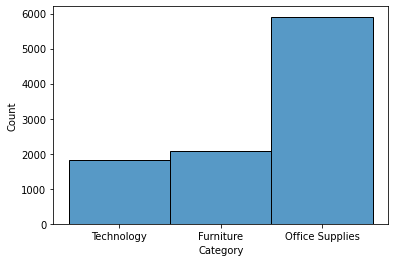

In [29]:
sns.histplot(data['Category'])

Больше всего (более половины товаров) покупают Office Supplies.

Далее рассмотрим распределение по подкатегориям внутри категорий:

<AxesSubplot:xlabel='Sub-Category', ylabel='Count'>

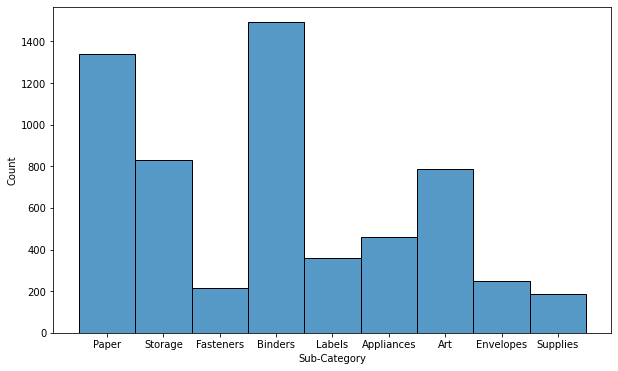

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(data[data['Category'] == 'Office Supplies']['Sub-Category'])

Больше всего среди товаров для офиса покупают бумагу и переплеты (Binders, не уверен в переводе).

<AxesSubplot:xlabel='Sub-Category', ylabel='Count'>

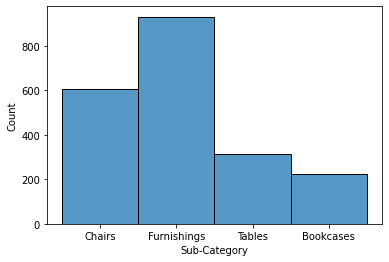

In [31]:
sns.histplot(data[data['Category'] == 'Furniture']['Sub-Category'])

Здесь большая часть приходится на Furnishings (вроде это меблировка, но не очень понятно, чем отличается от остального).

<AxesSubplot:xlabel='Sub-Category', ylabel='Count'>

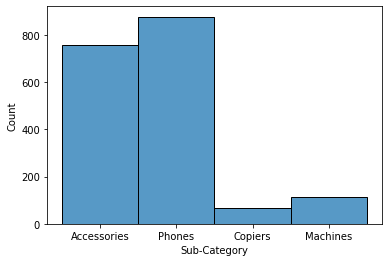

In [32]:
sns.histplot(data[data['Category'] == 'Technology']['Sub-Category'])

Здесь больше всего покупают телефоны и аксессуары.

График зависимости продаж от месяца в году:

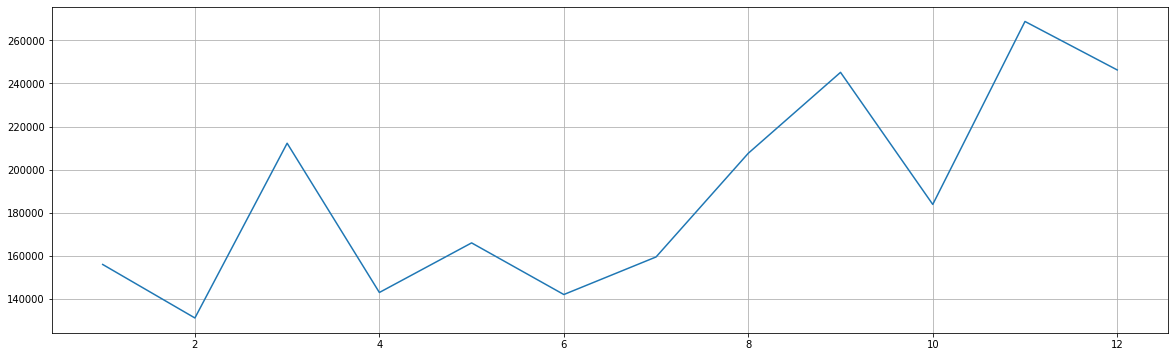

In [33]:
plt.figure(figsize=(20, 6))
plt.plot(data.groupby(['Month']).sum()['Sales'])
plt.grid(True)

Распределение купленных товаров между сегментами рынка в зависимости от месяца:

In [34]:
data.groupby(['Month', 'Segment']).count()['Order ID']

Month  Segment    
1      Consumer       324
       Corporate      133
       Home Office    118
2      Consumer       249
       Corporate      193
       Home Office     94
3      Consumer       453
       Corporate      211
       Home Office    133
4      Consumer       341
       Corporate      206
       Home Office    144
5      Consumer       411
       Corporate      263
       Home Office    144
6      Consumer       366
       Corporate      175
       Home Office    143
7      Consumer       402
       Corporate      209
       Home Office    113
8      Consumer       434
       Corporate      238
       Home Office    127
9      Consumer       576
       Corporate      349
       Home Office    191
10     Consumer       380
       Corporate      276
       Home Office    145
11     Consumer       623
       Corporate      365
       Home Office    206
12     Consumer       542
       Corporate      335
       Home Office    188
Name: Order ID, dtype: int64

График зависимости продаж от месяца с начала рассматриваемого периода:

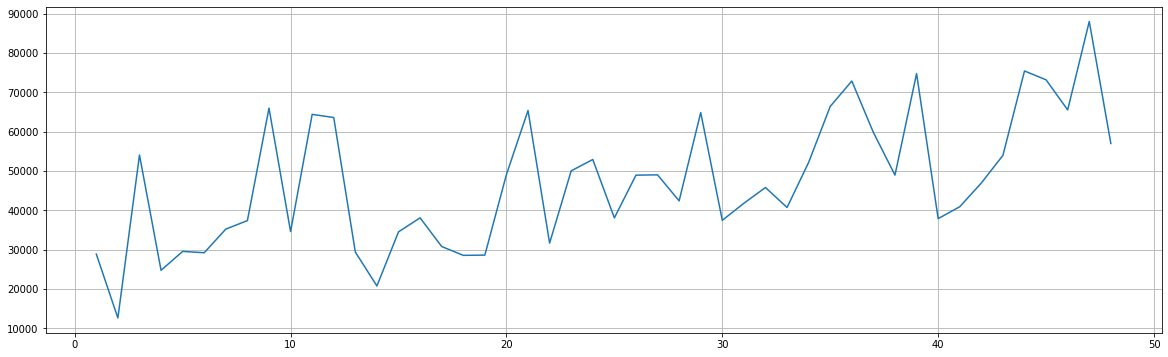

In [35]:
plt.figure(figsize=(20, 6))
plt.plot(data.groupby(['MfS']).sum()['Sales'])
plt.grid(True)

Видно, что присутствует некоторая сезонность.

График продаж по неделям с начала рассматриваемого периода:

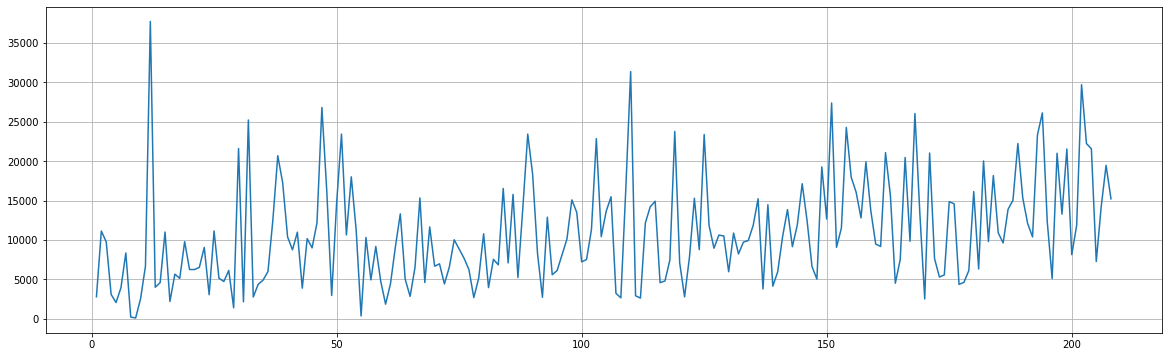

In [36]:
plt.figure(figsize=(20, 6))
plt.plot(data.groupby(['WfS']).sum()['Sales'])
plt.grid(True)

Так сезонность видно чуть лучше.

### **Гипотезы**

**1) В январе среднее значение sales меньше, чем в декабре**

In [37]:
sample_1 = data[data['Month'] == 1].groupby(['DoM']).sum()['Sales']
sample_2 = data[data['Month'] == 12].groupby(['DoM']).sum()['Sales']

Графики продаж в январе и декабре по дням:

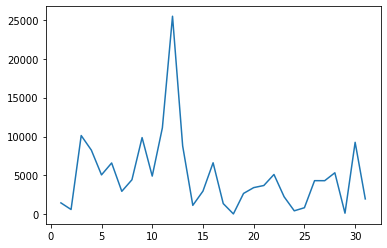

In [38]:
plt.plot(sample_1)

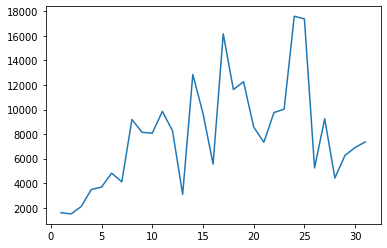

In [39]:
plt.plot(sample_2)

Проверим эти распределения на нормальность с помощью критерия Шапиро-Уилка:

In [40]:
stats.shapiro(sample_1)

ShapiroResult(statistic=0.774652898311615, pvalue=1.8130367607227527e-05)

Первое распределение не является нормальным.

In [41]:
stats.shapiro(sample_2)

ShapiroResult(statistic=0.9492931365966797, pvalue=0.14924822747707367)

Второе можно считать нормальным.

$H_0$: Средние значения sales за январь и февраль равны.

$H_1$: Среднее значение sales за январь меньше среднего значения sales за февраль.

Так как первое распределение нормальным не является, будем применять t-статистику:

In [42]:
stats.ttest_ind(sample_1, sample_2, alternative='less')

Ttest_indResult(statistic=-2.471313127546296, pvalue=0.008158978288774864)

p-value < 0.05, поэтому отвергаем $H_0$ в пользу $H_1$.

Проверим:

In [43]:
sample_1.mean()

5031.965012903226

In [44]:
sample_2.mean()

7944.081135483871

Действительно, среднее sample_1 меньше среднего sample_2.

**2) В январе клиенты из сегмента Consumer покупают меньше товаров, чем в феврале**

In [45]:
sample_1 = data[(data['Month'] == 1) & (data['Segment'] == 'Consumer')].groupby(['DoM']).count()['Order ID']
sample_2 = data[(data['Month'] == 12) & (data['Segment'] == 'Consumer')].groupby(['DoM']).count()['Order ID']

$H_0$: Функции распределения количества заказов в январе и декабре равны.

$H_1$: Функции распределения количества заказов в январе расположена левее функции распределения количества заказов в декабре.

Так как выборки не связаны между собой, будем применять критерий Манна-Уитни:

In [46]:
stats.mannwhitneyu(sample_1, sample_2, alternative='less')

MannwhitneyuResult(statistic=196.0, pvalue=0.00014667396475115524)

Принимаем гипотезу $H_1$.

Проверим средние:

In [47]:
sample_1.mean()

11.172413793103448

In [48]:
sample_2.mean()

18.066666666666666

### **Предсказание по Sales на следующий год**

In [49]:
weekly = data.groupby(['WfS']).sum()['Sales']

График продаж по неделям с начала рассматриваемого периода:

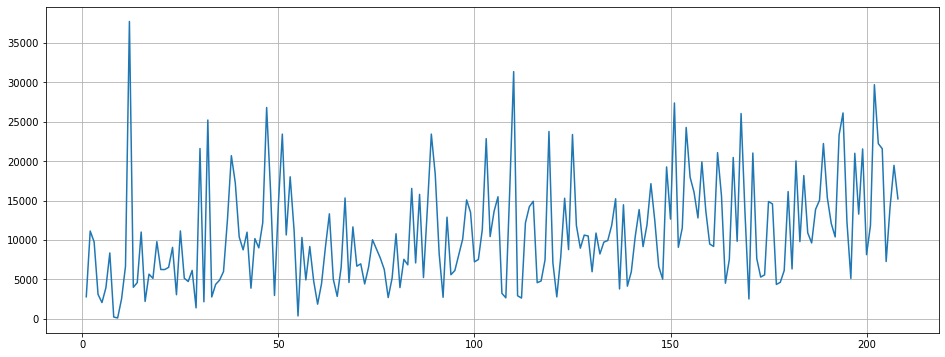

In [50]:
plt.figure(figsize=(16, 6))
plt.plot(weekly)
plt.grid(True)

На графике видна сезонность, поэтому будет использовать тройное экспоненциальное сглаживание.

In [51]:
fit = ExponentialSmoothing(np.array(weekly), seasonal_periods=52,trend='add', seasonal='add' ).fit()
preds = fit.forecast(52)  # предсказываем на 52 недели, т.е. 1 год

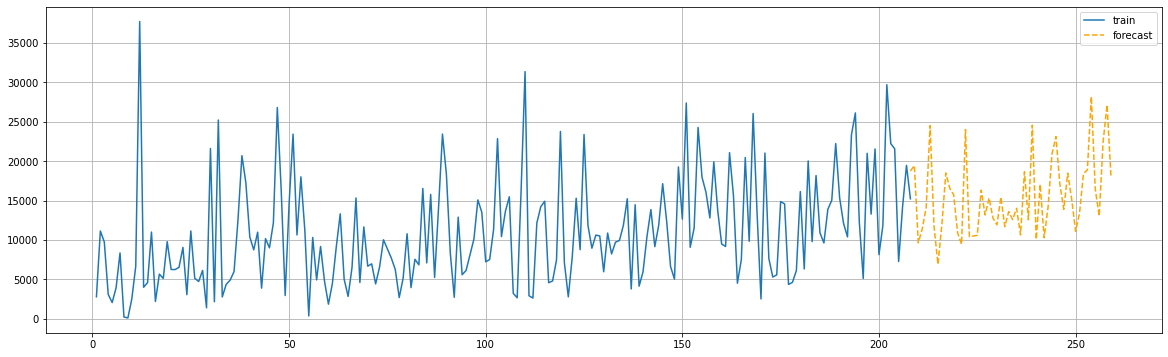

In [52]:
forecast = pd.Series(preds)  
plt.figure(figsize=(20,6))
plt.plot(weekly, label = 'train')
plt.plot(range(208, 260), forecast, '--', label = 'forecast', color = 'orange')
plt.legend()
plt.grid(True)
plt.show()

### **Выводы**

С помощью статистических гипотез было подтверждено, что продажи в январе падают по сравнению с декабрем. Прогноз показывает, что в следующем году продажи будут идти с той же сезонностью, но чуть меньшим разбросом.